Namespace(datafea='RMS', dataset='CWRU', source=3, target=0)
Source X shape: (10000, 1024); Source Y shape: (10000,)
Target X shape: (10000, 1024); Target Y shape: (10000,)



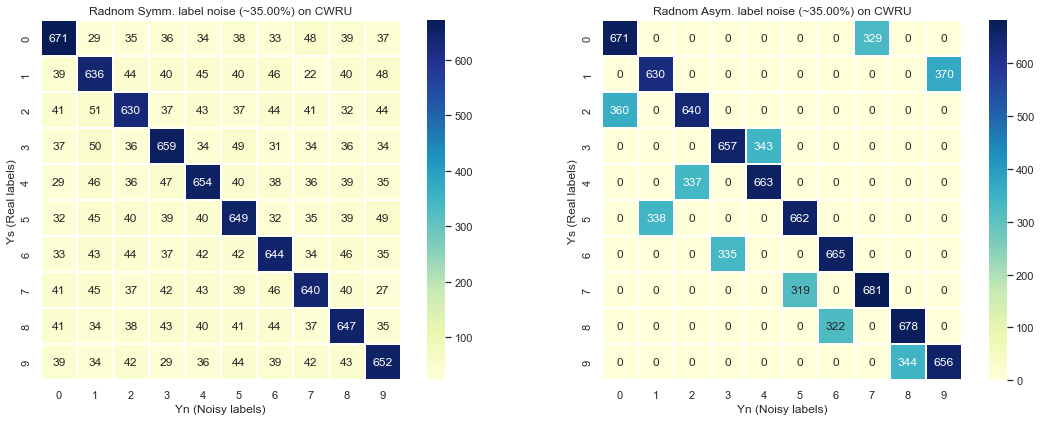

In [4]:
# -*- encoding: utf-8 -*-
'''
@File          :   aldbt_demo.py
@Time          :   2022/04/24 20:01:41
@Author        :   GuokLiu
@Contact       :   liuguokai@hust.edu.cn
@Institution   :   Huazhong Univ. of Sci. and Tech.
@Desc          :   Simulate symmetric and asymmetric label noise
'''


def flip_label(y, pattern, ratio, dt='CWRU', one_hot=False, random_seed=42):
    import numpy as np
    # Source: https://github.com/chenpf1025/noisy_label_understanding_utilizing
    # y: true label, one hot
    # pattern: 'Symm' or 'Asym'
    # p: float, noisy ratio

    y=y.copy()
    if dt=='CWRU':
        # Source: https://github.com/udibr/noisy_labels
        flip = {0:7, 1:9, 2:0, 3:4, 4:2, 5:1, 6:3, 7:5, 8:6, 9:8}
    else:
        print('Please assign your fliping dictionary')
    
    # convert one hot label to int
    if one_hot:
        y = np.argmax(y,axis=1) #[np.where(r==1)[0][0] for r in y]
    n_class = max(y)+1
    
    # filp label
    np.random.seed(random_seed)
    for i in range(len(y)):
        if pattern=='Symm':
            p1 = ratio/(n_class-1)*np.ones(n_class)
            p1[y[i]] = 1-ratio
            y[i] = np.random.choice(n_class,p=p1)
        elif pattern=='Asym':
            # y[i] = np.random.choice([y[i],(y[i]+1)%n_class],p=[1-ratio,ratio])            
            y[i] = np.random.choice([y[i],flip[y[i]]],p=[1-ratio,ratio])            
            
    # convert back to one hot
    if one_hot:
        y = np.eye(n_class)[y]
    return y


def check_label_noise(ax, Ys, Yn1, Yn2, ratio, type):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns; sns.set_theme()
    cm1 = confusion_matrix(Ys, Yn1)
    cm2 = confusion_matrix(Ys, Yn2)
    if len(ax)==1:
        ax = sns.heatmap(cm1, annot=True, square=True, fmt='d', linewidth=0.2, cmap="YlGnBu")
        ax.set_title('Radnom {}. label noise (~{:.2f}%) on CWRU'.format(type[0], ratio[0]*100))
        ax.set_ylabel('Ys (Real labels)')
        ax.set_xlabel('Yn (Noisy labels)')
    elif len(ax)==2:
        # Symm. visualization
        sns.heatmap(cm1, annot=True, square=True, fmt='d', linewidth=0.2, cmap="YlGnBu",ax=ax[0])
        ax[0].set_title('Radnom {}. label noise (~{:.2f}%) on CWRU'.format(type[0], ratio[0]*100))
        ax[0].set_ylabel('Ys (Real labels)')
        ax[0].set_xlabel('Yn (Noisy labels)')

        # Asym. visualization
        sns.heatmap(cm2, annot=True, square=True, fmt='d', linewidth=0.2, cmap="YlGnBu",ax=ax[1])
        ax[1].set_title('Radnom {}. label noise (~{:.2f}%) on CWRU'.format(type[1], ratio[1]*100))
        ax[1].set_ylabel('Ys (Real labels)')
        ax[1].set_xlabel('Yn (Noisy labels)')
    plt.tight_layout()
    


if __name__=='__main__':
    import argparse
    import matplotlib.pyplot as plt
    from utils_aldbl import TaskScheduler

    parser = argparse.ArgumentParser('Setting model parameters')
    parser.add_argument('-dt', '--dataset', type=str, default='CWRU', help='dataset name')
    parser.add_argument('-df', '--datafea', type=str, default='RMS', help='data feature')
    parser.add_argument('-sr', '--source', type=int, default=3, help='index of source domain')
    parser.add_argument('-tg', '--target', type=int, default=0, help='index of target domain')
    args, unknown = parser.parse_known_args()
    print(args)

    # Load source and target data with clean labels
    Xs, Ys, Xt, Yt = TaskScheduler(args)

    # Simulate label noise
    Yn1 = flip_label(Ys, 'Symm', 0.35, dt=args.dataset)
    Yn2 = flip_label(Ys, 'Asym', 0.35, dt=args.dataset)

    # Check simulated labels
    fig, ax = plt.subplots(1,2, figsize=(16,6))
    check_label_noise(ax, Ys, Yn1, Yn2, [0.35, 0.35], ['Symm', 'Asym'])
    plt.savefig('ALDBL-Github/Figures/Simulation.png', dpi=300)